In [3]:
import numpy as np
import tensorflow as tf

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

In [4]:
# Download an image and read it into a NumPy array, 
def download(url):
    name = url.split("/")[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = image.load_img(image_path,target_size = (1000,1000))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img

In [5]:
# Scale pixels to between (-1.0 and 1.0)
# def preprocess(img):
#     return (img / 127.5) - 1

In [6]:
# Undo the preprocessing above
def deprocess(img):
    img[:,:,0] += 103.939
    img[:,:,1] += 116.779
    img[:,:,2] += 123.68
    img = img[:, :, ::-1]
    img =  np.clip(img, 0, 255).astype('uint8')
    return img

In [7]:
# Display an image
def show(img):
    if(len(img.shape) == 4):
        img = np.squeeze(img, axis = 0)
    img = deprocess(img)
    plt.figure(figsize=(12,12))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.imshow(img)
    return

In [8]:
content_path = 'https://www.gardeningknowhow.com/wp-content/uploads/2020/12/lonely-japanese-cherry.jpg'
noise_path = 'https://thumbs.dreamstime.com/b/grey-noise-texture-illustration-noise-texture-bacground-available-high-resolution-jpeg-grey-noise-texture-illustration-noise-116732588.jpg'
style_path = 'https://t3.ftcdn.net/jpg/00/97/11/32/360_F_97113297_P1NxOXOzB8FPGwfMEghJJhPFgxwkLPha.jpg'

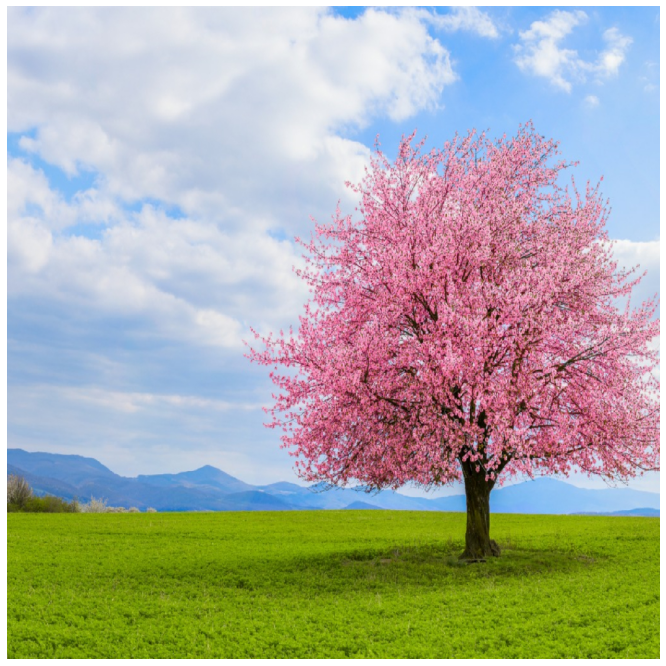

In [9]:
content_image = download(content_path)
show(content_image)

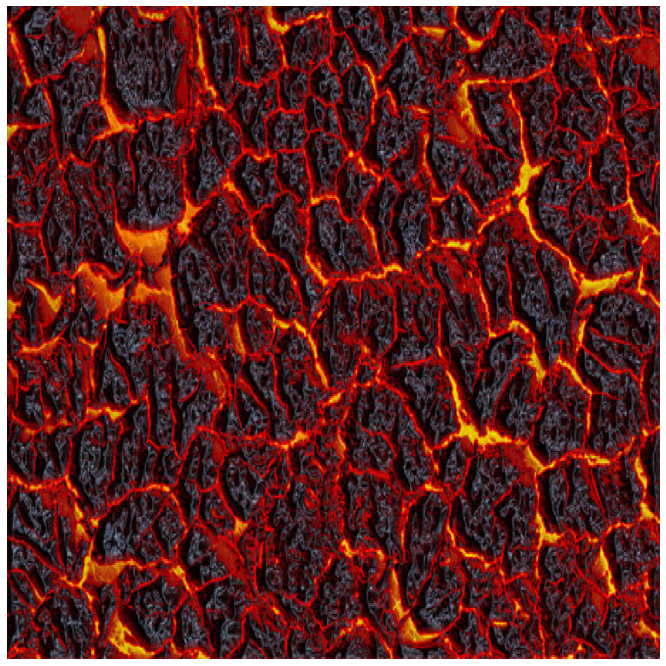

In [10]:
style_image = download(style_path)
show(style_image)

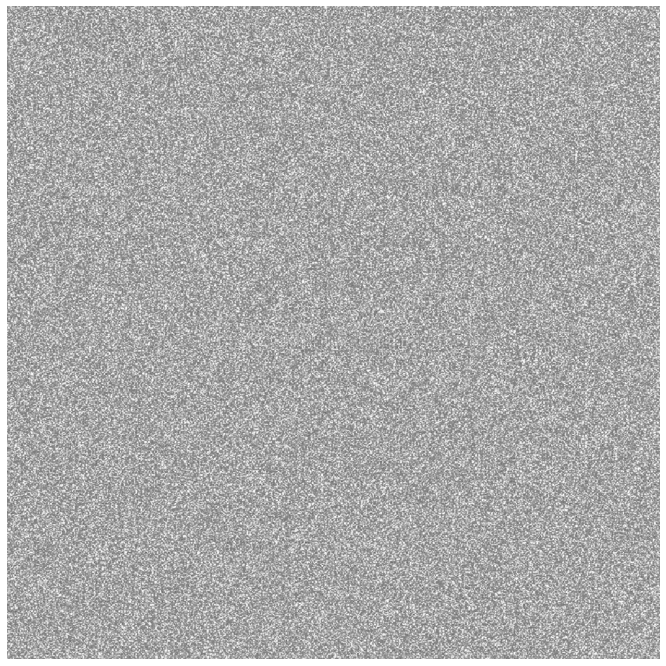

In [11]:
noise_image = download(noise_path)
show(noise_image)

In [12]:
model = tf.keras.applications.VGG16(include_top = False, weights = 'imagenet')
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

<img src="https://camo.githubusercontent.com/046b49a901c34426fa40a33d23337805b66a3d22/68747470733a2f2f7777772e7265736561726368676174652e6e65742f70726f66696c652f436c6966666f72645f59616e672f7075626c69636174696f6e2f3332353133373335362f6669677572652f666967322f41533a36373033373132373134313337373740313533363834303337343533332f6c6c757374726174696f6e2d6f662d7468652d6e6574776f726b2d6172636869746563747572652d6f662d5647472d31392d6d6f64656c2d636f6e762d6d65616e732d636f6e766f6c7574696f6e2d46432d6d65616e732e6a7067" />

In [13]:
style_layers = ['block1_conv1', 'block3_conv1', 'block5_conv1']
content_layer = 'block5_conv1'

# style_layers = [model.get_layer(current_layer).output for current_layer in style_layers]
# content_layer = [model.get_layer(current_layer).output for current_layer in content_layer]

In [14]:
content_model = Model(inputs = model.input, outputs = model.get_layer(content_layer).output)
style_models = [Model(inputs = model.input, outputs = model.get_layer(current_layer).output) for current_layer in style_layers]

In [15]:
content_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
style_models[0].summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


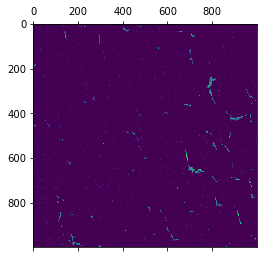

In [17]:
index = 0
a_S = style_models[index](style_image)
plt.matshow(a_S[0,:,:,12])

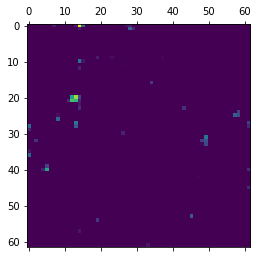

In [18]:
index = 2
a_S = style_models[index](style_image)
plt.matshow(a_S[0,:,:,12])

In [19]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

In [20]:
def gram_matrix(A):
    channel = A.shape[-1]
    A = tf.reshape(A, (-1, channel))
    n = tf.shape(A)[0]
    gram = tf.matmul(A,A, transpose_a = True)
    return gram/tf.cast(n, tf.float32)

In [21]:
lam = 1/len(style_models)
def style_cost(style, generated):
    J_style = 0
    current_cost = []
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        G_s = gram_matrix(a_S)
        G_g = gram_matrix(a_G)
#         current_cost.append(tf.reduce_mean(tf.square(G_s - G_g)))
        J_style += tf.reduce_mean(tf.square(G_s - G_g))
    return J_style

In [22]:
generated_images = []
def trainig_loop(content_path, style_path, noise_path, iterations, alpha, beta, lr_rate):
    content = download(content_path)
    style = download(style_path)
    noise = download(noise_path)
    generated = tf.Variable(noise)
    
    opt = tf.optimizers.Adam(learning_rate = lr_rate)
    J_min = 1e12 + 0.1
    for i in range(iterations):
        with tf.GradientTape(persistent = True) as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_cost = alpha*J_content + beta*J_style
        
        grads = tape.gradient(J_cost, generated)
        opt.apply_gradients([(grads, generated)])
        if J_cost < J_min:
            J_min = J_cost
            best_pic = generated.numpy()
        print('cost at iteration ' + str(i) + ' = ' + str(J_cost.numpy()))
        generated_images.append(generated.numpy())
    return best_pic

In [23]:
# generated = tf.Variable(tf.compat.v1.random_normal(shape = (1,1000, 1000, 3)))

In [24]:
itr = 180
alpha = 10
beta = 80
lr_rate = 8

final = trainig_loop(content_path,noise_path,style_path,itr,alpha, beta, lr_rate)